In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn

Load and Prepare Data

We load the train and test datasets, add a placeholder `SalePrice` column to the test set, and combine both using `concat`.  
We also set `Id` as the index to uniquely identify each row.

In [3]:
df_1 = pd.read_csv("/Users/k.melisayegen/Desktop/house_prices/train.csv")
df_2 = pd.read_csv("/Users/k.melisayegen/Desktop/house_prices/test.csv")
if 'SalePrice' not in df_2.columns:
    df_2['SalePrice'] = 0
df = pd.concat([df_1, df_2], axis = 0)
df = df.set_index('Id')

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We noticed that the dataset contains missing (`NaN`) values.  
To analyze them, we create a new DataFrame called `df_null` that includes only the columns with at least one missing value.

This helps us understand which parts of the data are incomplete, and it allows us to clean the dataset properly before training our regression model — ensuring more accurate results.


In [5]:
df_null= df[df.isnull().sum()[df.isnull().sum()>0].index]

To verify what we extracted, we use the `.head()` function to preview `df_null`.

We can see that 34 columns contain at least one `NaN` value.  
This confirms that our filtering worked as expected.

In [6]:
df_null.head()

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,...,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
2,RL,80.0,NaN,AllPub,MetalSd,MetalSd,NaN,0.0,Gd,TA,...,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
3,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,...,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
4,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,NaN,0.0,TA,Gd,...,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
5,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,...,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD


To better understand the distribution of missing values across columns, we create a heatmap.

This allows us to quickly spot which columns have a high number of `NaN` values.  
Columns with too many missing entries can be considered for removal to improve data quality.



<Axes: ylabel='Id'>

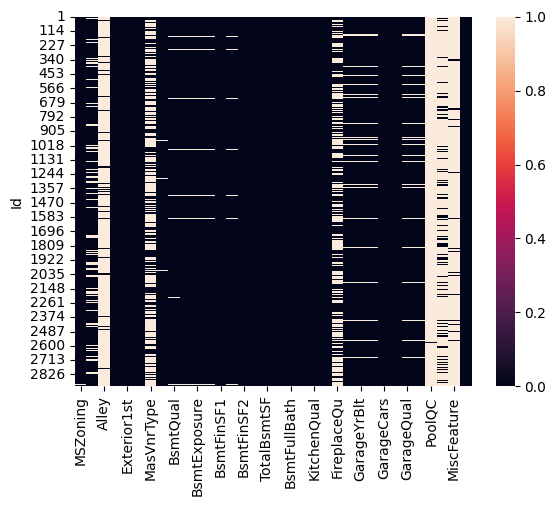

In [7]:
sns.heatmap(df_null.isnull())

From the heatmap, we noticed that some columns (like `PoolQC` and `Alley`) contain a large number of missing values. These features likely don't add much useful information, so we decide to remove them.

We start by isolating all object (string) columns in a new DataFrame.  
Then, we drop any object column from the main dataset that has more than 1100 missing values.  
This threshold can be adjusted based on the needs of the analysis, but the goal is to remove columns with too many `NaN` values.


In [8]:
df_objects= df[df.select_dtypes(include=['object']).columns]
df = df.drop(df[df_objects.isna().sum()[df_objects.isna().sum() > 1100].index], axis=1)

Just like with the main DataFrame, we also clean `df_objects` by dropping columns with excessive missing values.

To prepare the object (categorical) data for modeling, we fill any remaining `NaN` values with the placeholder `'null'`.  
This ensures no missing values remain before encoding.

Since most machine learning models require numerical input, we use `pd.get_dummies()` to one-hot encode the categorical features.  
This creates a new DataFrame, `df_objects_encoded`, where each category is represented as a separate binary column.


In [9]:
df_objects = df_objects.drop(df_objects[df_objects.isna().sum()[df_objects.isna().sum()>1100].index], axis=1)

df_objects = df_objects.fillna('null')

df_objects_encoded = pd.get_dummies(df_objects)

When examining the values within a single column, such as MSZoning, we observe that there is a null category represented by NaN values. The following code displays the count of each unique value in this column:

In [10]:
df_objects['MSZoning'].value_counts()

MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
null          4
Name: count, dtype: int64

When inspecting the encoded DataFrame, we can see that the indicated columns contain only True or False values.

In [11]:
df_objects_encoded.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_null,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_null,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
2,False,False,False,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,False,False,False,True,False,False,False,True,True,False,...,False,False,True,False,False,False,False,False,True,False
4,False,False,False,True,False,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
5,False,False,False,True,False,False,False,True,True,False,...,False,False,True,False,False,False,False,False,True,False


Next, we replace the relevant values in the encoded DataFrame with null, and then print the column names to verify the changes.

In [12]:
for i in df_objects_encoded.columns: 
    if 'null' in i:
        df_objects_encoded = df_objects_encoded.drop(i, axis=1)
        print(i)

MSZoning_null
Utilities_null
Exterior1st_null
Exterior2nd_null
BsmtQual_null
BsmtCond_null
BsmtExposure_null
BsmtFinType1_null
BsmtFinType2_null
Electrical_null
KitchenQual_null
Functional_null
GarageType_null
GarageFinish_null
GarageQual_null
GarageCond_null
SaleType_null


We create a new DataFrame, new_df, by concatenating the original DataFrame df with the encoded DataFrame df_objects_encoded along the columns (axis=1). This combines both datasets one on the others top.

In [13]:
new_df= pd.concat([df, df_objects_encoded], axis=1)

To verify the number of columns in each DataFrame, we use the len() function to check the column counts of new_df, the original DataFrame df, and the encoded DataFrame df_objects_encoded

In [14]:
len(new_df.columns)

304

In [15]:
len(df.columns), len(df_objects_encoded.columns)

(74, 230)

Next steps:
Remove categorical variables that require encoding.
Focus analysis on numerical features only.
Identify columns with remaining missing values that still require handling.

In [ ]:
new_df= new_df.drop(df.select_dtypes(include=['object']), axis=1)

new_df.isna().sum()[new_df.isna().sum() > 0]

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

There are 11 columns in the dataset that contain missing values. While it’s common to fill missing values with the mean, some columns are not suitable for this approach. For example, columns like GarageArea (the size of the garage in car capacity) or GarageYrBlt (the year the garage was built) don’t have meaningful averages. For these, it is more appropriate to fill missing values using the mode (most frequent value).

We separate the columns into two lists:

Mode_columns for columns to fill with mode values.
Mean_columns for columns to fill with mean values.
After filling the missing values accordingly, we verify that no columns contain null values.

In [17]:
Mode_columns = ['GarageYrBlt', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']
Mean_columns = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']

for i in Mode_columns:
    new_df[i]= new_df[i].fillna(new_df[i].mode()[0])
    
for i in Mean_columns:
    new_df[i]= new_df[i].fillna(np.round(new_df[i].mean()))
    
new_df.isna().sum()[new_df.isna().sum()>0]

Series([], dtype: int64)

Now that our dataset has no missing values, we can proceed with visualization and predicting the sale price. Since we merged the training and test datasets earlier for cleaning, we need to split them back into their original parts. Additionally, we drop the SalePrice column from the test data, as it is not available for the test set.

In [18]:
training_data = new_df[0:len(df_1)]
test_data = new_df[len(df_1):]

test_data= test_data.drop(columns='SalePrice')

Now that we have finished cleaning and merging the datasets, we can proceed to train our model. First, we import necessary libraries.

In [19]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Feature/Target Split:
X contains all features (excluding SalePrice), y is the target (SalePrice).
Train/Test Split:
80% training, 20% testing using train_test_split.
Reshaping:
Y_train and Y_test reshaped to 2D arrays for compatibility with ML models.
Output:
X_train.shape: (1168, 266) → 1168 samples, 266 features
Y_train.shape: (1168, 1) → 1168 target values and 1 column

In [22]:
X = training_data.drop(columns='SalePrice')
y = training_data['SalePrice']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
Y_train = np.reshape(Y_train, (-1,1))
Y_test = np.reshape(Y_test, (-1,1))
X_train.shape, Y_train.shape 

((1168, 266), (1168, 1))

Next, I trained three different models to predict house prices: Linear Regression, Random Forest Regression, and Polynomial Regression (with degree 2). After evaluating them using Mean Squared Error (MSE), I observed that the Random Forest model produced the lowest error, indicating the best performance among the three.

In [24]:
model_1 = LinearRegression()
model_1.fit(X_train, Y_train)
y_pred = model_1.predict(X_test)
mean_squared_error(Y_test, y_pred)

619738400.1366006

In [27]:
model_2 = RandomForestRegressor(n_estimators=100)
model_2.fit(X,y)
y_pred = model_2.predict(X_test)
mean_squared_error(Y_test, y_pred)

78794080.99738084

In [31]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
model_3 = LinearRegression()
model_3.fit(X_poly, Y_train)
X_test_poly = poly.transform(X_test)
y_pred = model_3.predict(X_test_poly)
mean_squared_error(Y_test, y_pred)

38351336639.35053

To visually compare the predicted house prices with the actual values, we flatten both arrays and sort them by the true target values (Y_test). This allows us to generate a clearer comparison between actual and predicted values using a line plot.

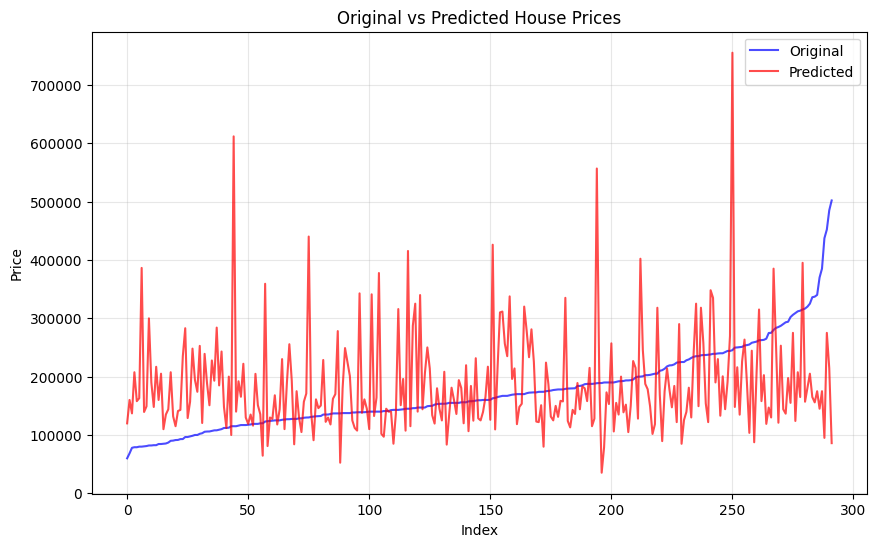

In [ ]:
Y_test_flat = Y_test.ravel()
y_pred_flat = y_pred.ravel()

sort_indices = np.argsort(Y_test_flat)

plt.figure(figsize=(10,6))
plt.plot(np.arange(len(Y_test_flat)), Y_test_flat[sort_indices], 
         label='Original', color='blue', alpha=0.7)
plt.plot(np.arange(len(Y_test_flat)), y_pred_flat[sort_indices], 
         label='Predicted', color='red', alpha=0.7)

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Original vs Predicted House Prices')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


After training the Random Forest model, we use it to predict house prices on the test dataset. The predictions are then stored in a new DataFrame along with the corresponding Id values (taken from the test data index). Finally, we export the results to a CSV file for submission or further analysis.

In [74]:
rf_pred = model_2.predict(test_data)

final_rf= pd.DataFrame()
final_rf['Id']= test_data.index
final_rf['SalePrice'] = rf_pred

final_rf.to_csv('rf_output.csv', index=False)